# Simulations of nitrogen in cc-pvdz basis

58 qubit simulation of the LUCJ ansatz using matrix product state simulators

Diagonalization of FCI wavefunction is impossible, so we employ DMRG at $\chi=1024$ as our CI reference.

Comparisons between LUCJ, LUCJ + SQD, CCSD, CCSD(T) and the DMRG reference solution

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tikzplotlib

/home/david/.venvs/tikzplot/lib/python3.12/site-packages/numpy/_core/getlimits.py:551: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


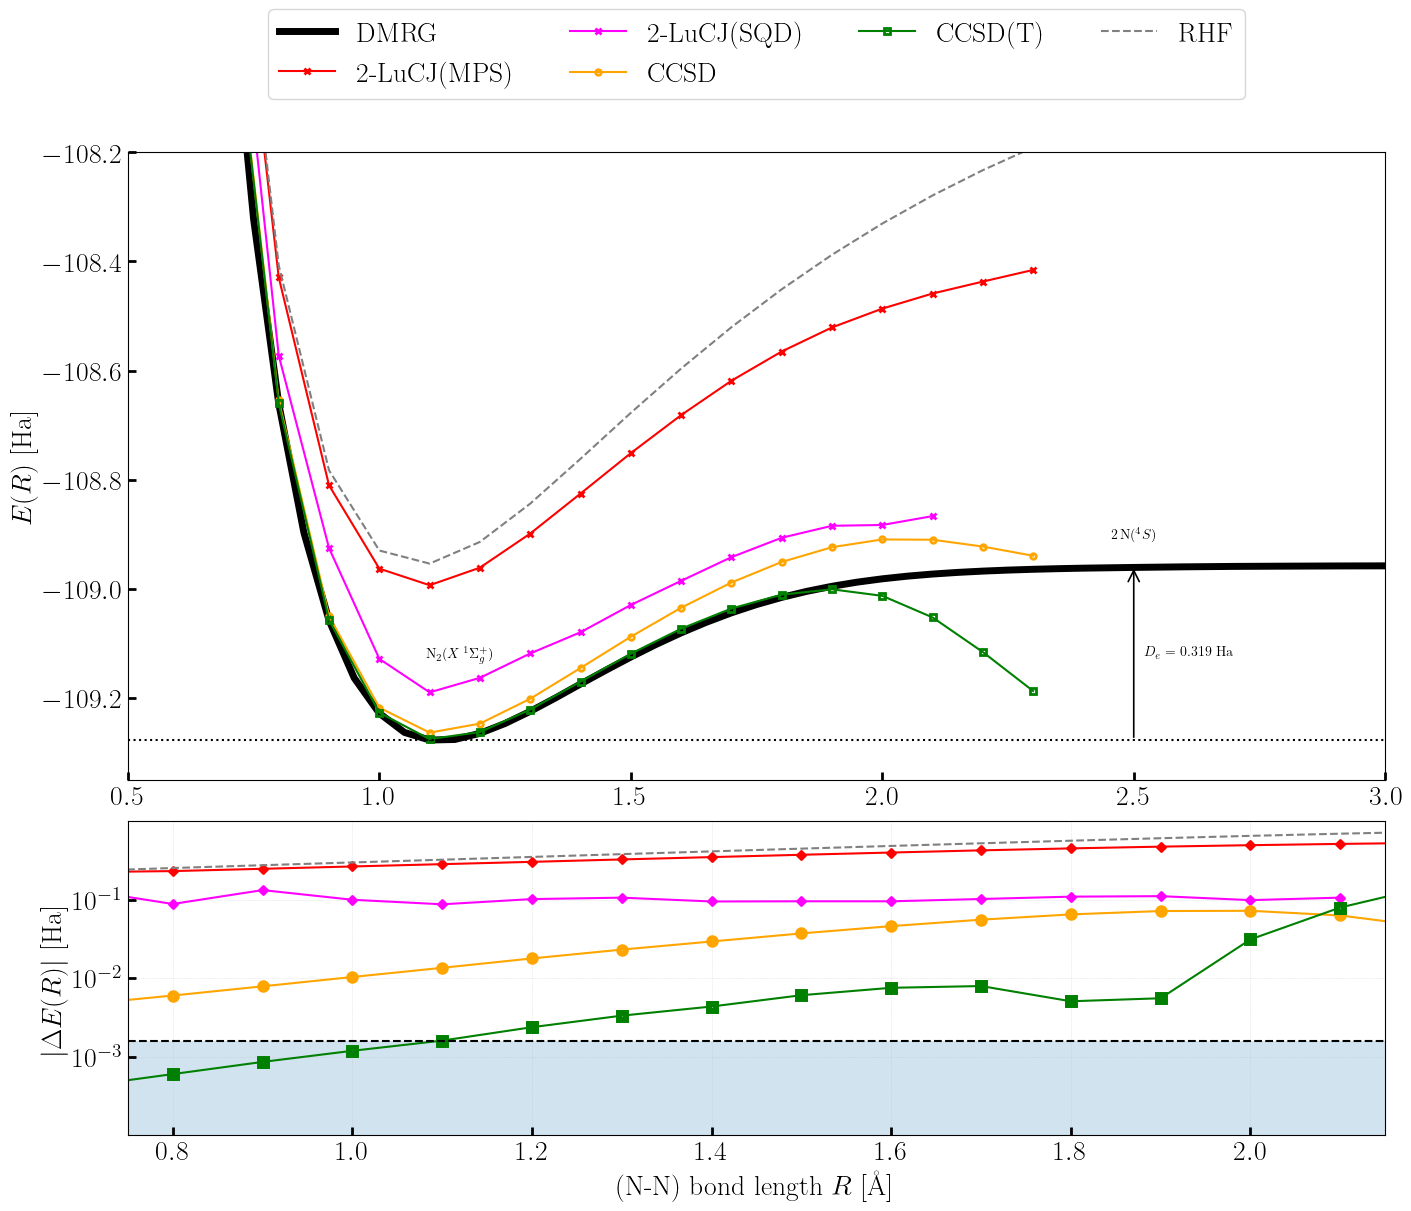

In [5]:

mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.unicode_minus": False
})


plt.rcParams.update({
    "font.size": 20,
    "axes.titlesize": 20,
    "axes.labelsize": 20,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "legend.fontsize": 20,
    "figure.titlesize": 20,
})
plt.rcParams.update({"lines.markersize":2, "lines.markeredgewidth":5, "xtick.major.size":3, "xtick.minor.size":3, "ytick.major.size":3, "ytick.minor.size":3, "xtick.direction":"in", "ytick.direction":"in"}) 

curve_configs = [
    (
        "DMRG",
        "../data/dmrg/dmrgci/n2_ccpvdz(10e,26o)_bd=1024.csv",
        1,
        {"c": "k", "ls": "-", "marker": "", "lw": 5, "ms": 4, "markeredgewidth": 5},
    ),
    (
        r"2-LuCJ(MPS)",
        "../data/mps/cc-pvdz/n2_bd=512_k=2.csv",
        1,
        {"c": "red", "ls": "-", "marker": "x", "lw": 1.5, "ms": 5, "markeredgewidth": 2},
    ),
    (
        r"2-LuCJ(SQD)",
        "../data/tns/n2_ccpvdz_sqd.csv",
        1,
        {"c": "magenta", "ls": "-", "marker": "x", "lw": 1.5, "ms": 5, "markeredgewidth": 2},
    ),
    (
        "CCSD",
        "../data/ccsd/n2_cc-pvdz.csv",
        2,
        {"c": "orange", "ls": "-", "marker": "o", "lw": 1.5, "ms": 4, "markeredgewidth": 2},
    ),
    (
        "CCSD(T)",
        "../data/ccsd/n2_cc-pvdz.csv",
        3,
        {"c": "green", "ls": "-", "marker": "s", "lw": 1.5, "ms": 4, "markeredgewidth": 2},
    ),
    (
        "RHF",
        "../data/ccsd/n2_cc-pvdz.csv",
        1,
        {"c": "gray", "ls": "--", "marker": "", "lw": 1.5, "ms": 4, "markeredgewidth": 2},
    ),
]

curves = []
for label, filename, e_col, style in curve_configs:
    data = np.loadtxt(filename, delimiter=",", skiprows=1)
    R = data[:, 0]
    E = data[:, e_col]
    curves.append((label, R, E, style))

ref_label = "DMRG"
R_ref = None
E_ref = None
for label, R, E, style in curves:
    if label == ref_label:
        R_ref = R
        E_ref = E
        break

tol = 1e-8
err_R = {}
err_val = {}

for label, R, E, style in curves:
    if label == ref_label:
        continue
    R_list = []
    e_list = []
    for r_val, e_val in zip(R, E):
        idx = np.where(np.isclose(R_ref, r_val, atol=tol))[0]
        if idx.size > 0:
            R_list.append(r_val)
            e_list.append(abs(e_val - E_ref[idx[0]]))
    err_R[label] = np.array(R_list)
    err_val[label] = np.array(e_list)

fig, (ax1, ax2) = plt.subplots(
    2,
    1,
    figsize=(14, 12),
    gridspec_kw={"height_ratios": [2, 1]},
    constrained_layout=True,
)

for label, R, E, style in curves:
    ls = style["ls"] if style["ls"] != "" else "none"
    marker = style["marker"] if style["marker"] != "" else None

    ax1.plot(
        R,
        E,
        ls=ls,
        marker=marker,
        lw=style["lw"],
        c=style["c"],
        markersize=style["ms"],
        markerfacecolor=style["c"],
        markeredgewidth=style["markeredgewidth"],
        fillstyle="none",
        label=label,
    )

ax1.set_ylabel(r"$E(R)$ [Ha]")

for label, R in err_R.items():
    if R.size == 0:
        continue
    style = next(s for lab, _, _, s in curves if lab == label)
    ls = style["ls"] if style["ls"] != "" else "none"
    marker = style["marker"] if style["marker"] != "" else None

    ax2.semilogy(
        R,
        np.maximum(err_val[label], 1e-120),
        ls=ls,
        marker=marker,
        lw=style["lw"],
        c=style["c"],
        markersize=style["ms"],
        markerfacecolor=style["c"],
        fillstyle="none",
        label=label,
    )

ax2.set_ylabel(r"$|\Delta E(R)|$ [Ha]")
ax2.set_xlabel(r"(N-N) bond length $R$ [Å]")
ax2.grid(True, linestyle=":", linewidth=0.5, alpha=0.5)
ax2.axhline(1.594e-3, linestyle="--", c="k")
ax2.fill_between((0.75, 2.15), 1e-4, 1.594e-3, alpha=0.2)
ax2.set_ylim(1e-4, 1)
ax2.set_xlim(0.75, 2.15)
ax2.set_yticks([1e-3, 1e-2, 1e-1])
ax2.minorticks_off()
ax1.set_ylim(-109.35,-108.2)

handles, labels = ax1.get_legend_handles_labels()
leg = ax1.legend(
    handles,
    labels,
    loc="upper center",
    ncol=4,
    bbox_to_anchor=(0.5, 1.25),
    frameon=True,
)
d = np.loadtxt("../data/dmrg/dmrgci/n2_ccpvdz(10e,26o)_bd=1024.csv", skiprows=1, delimiter=',')
R, E_DMRG = d[:,0], d[:,1]

idx_min = np.argmin(E_DMRG)
R_e = R[idx_min]
E_min = E_DMRG[idx_min]
E_inf = E_DMRG[-1]
De = E_inf - E_min

x_left, x_right = ax1.get_xlim()
x_arrow = 2.5

ax1.axhline(E_min, linestyle=":", color="k")

ax1.annotate(
    "",
    xy=(x_arrow, E_inf),
    xytext=(x_arrow, E_min),
    arrowprops=dict(arrowstyle="->", lw=1.2, color="k"),
    clip_on=False,
)

ax1.text(
    x_arrow + 0.02,
    0.5 * (E_min + E_inf),
    r"$D_e = %.3f\ \mathrm{Ha}$" % De,
    va="center",
    ha="left",
    fontsize=10
)

ax1.text(
    R_e + 0.06,
    E_min + 0.15,
    r"$\mathrm{N_2}(X\,^1\Sigma_g^+)$",
    ha="center",
    fontsize=10
)
ax1.text(
    2.5,
    E_inf + 0.05,
    r"$2\,\mathrm{N}(^4S)$",
    ha="center",
    fontsize=10
)
ax1.set_xlim(0.5,3)

ax1.tick_params(which="both", length=6, width=2)
ax2.tick_params(which="both", length=6, width=2)
fig.savefig("output/n2_ccpvdz.svg", dpi=1000, bbox_inches="tight")
tikzplotlib.save( "figures/N2_ccpvdz.tex", 
                 axis_width="0.9\\linewidth", 
                 axis_height="0.5\\linewidth", 
                 textsize=6, 
                 extra_axis_parameters=[ "tick label style={font=\\scriptsize}", "label style={font=\\footnotesize}", "title style={font=\\footnotesize}", "legend style={font=\\scriptsize}", r"legend style={font=\scriptsize, "
        r"/tikz/every even column/.append style={column sep=0.5cm}}",], 
                 extra_groupstyle_parameters=[ "horizontal sep=1.0cm",  ] )
